[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/b-koopman/VLM_inference/blob/main/VLM_inference_pt1_architectures.ipynb)

Recommend running on an L4 instance to avoid memory issues, otherwise you might need to restart/re-run cells. (TODO: more efficiently re-use VRAM, or use smaller model examples)

# VLM (Vision-Language Models) Inference (Part 1: Architecture)

This notebook will cover architectures of open source models, focusing mainly on LlaVA based architectures, as I find those offer the most intuitive understanding of how images or multimodal content can be passed into an LLM. First, let's focus on how Qwen2.5VL's architecture, and how it is implemented in HF transformers.


### How are images represented in LLMs in the first place?

Since Qwen VL flavors are based on the LLaVA architecture, we can reference the paper [Visual Instruction Tuning, Haotian Liu et al.](https://arxiv.org/pdf/2304.08485) for basic details on architecture, and training (to be addressed later on in this doc).

I find it easier to digest, taken in the broader context of the end-to-end flow of data, especially comparing text only, vs. text+image.


#### Text only LLM
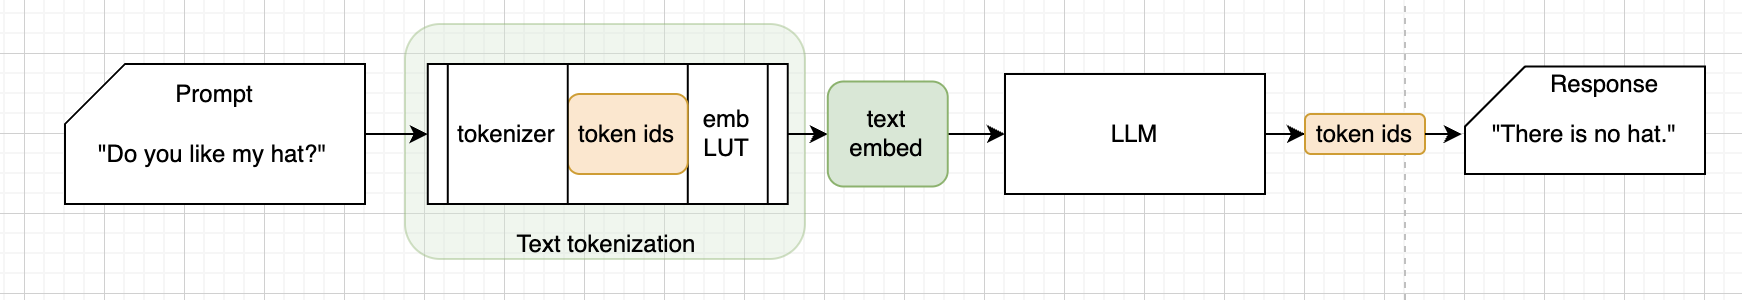

#### LLaVA, using an image + text

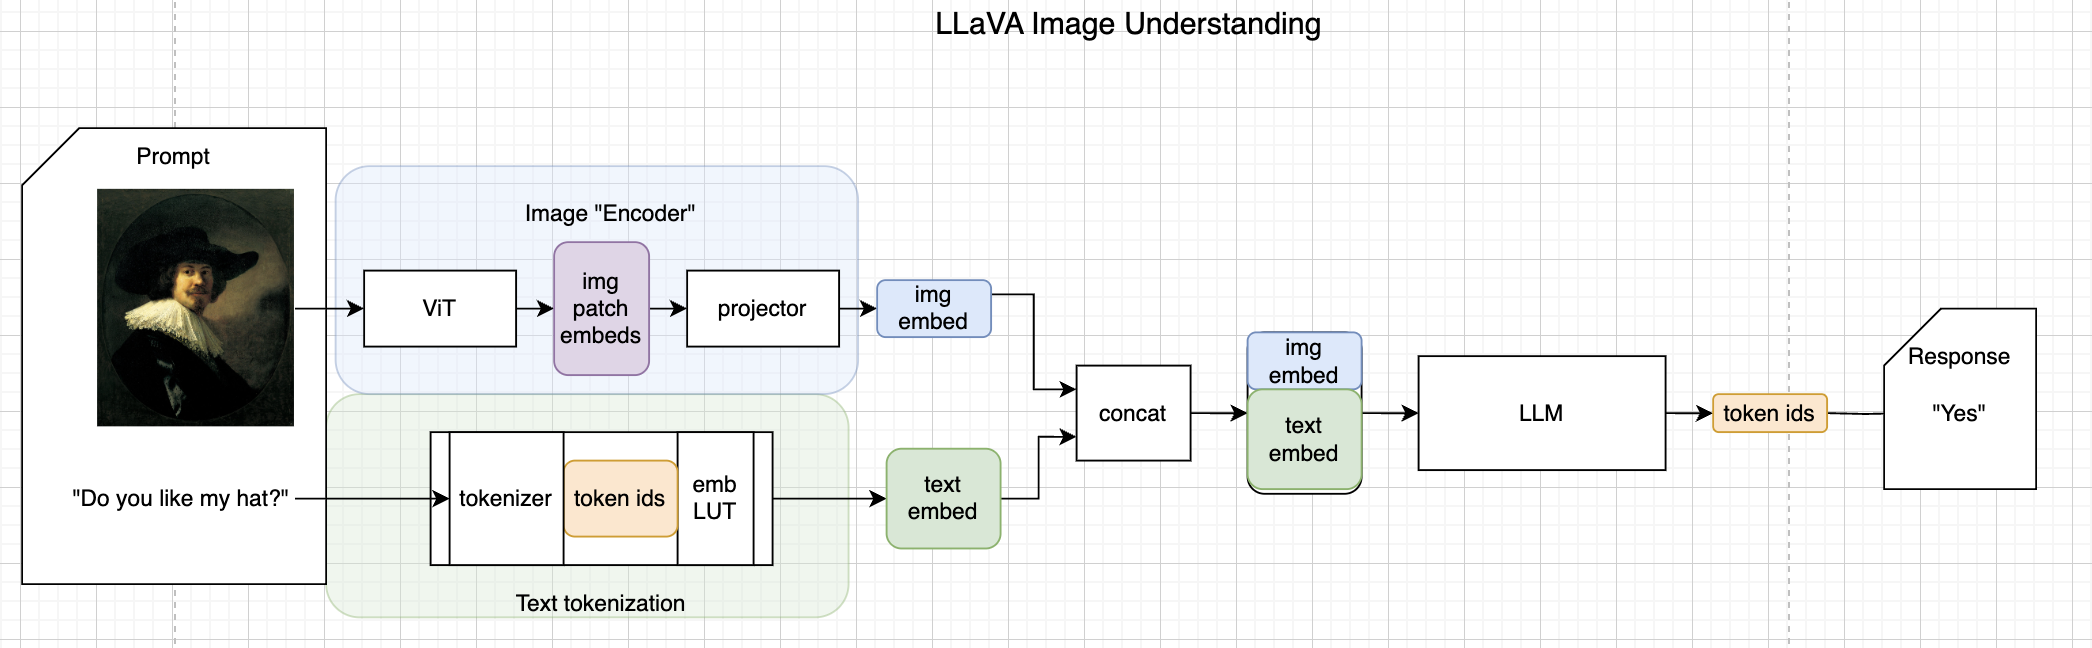



#### Qwen2.5VL

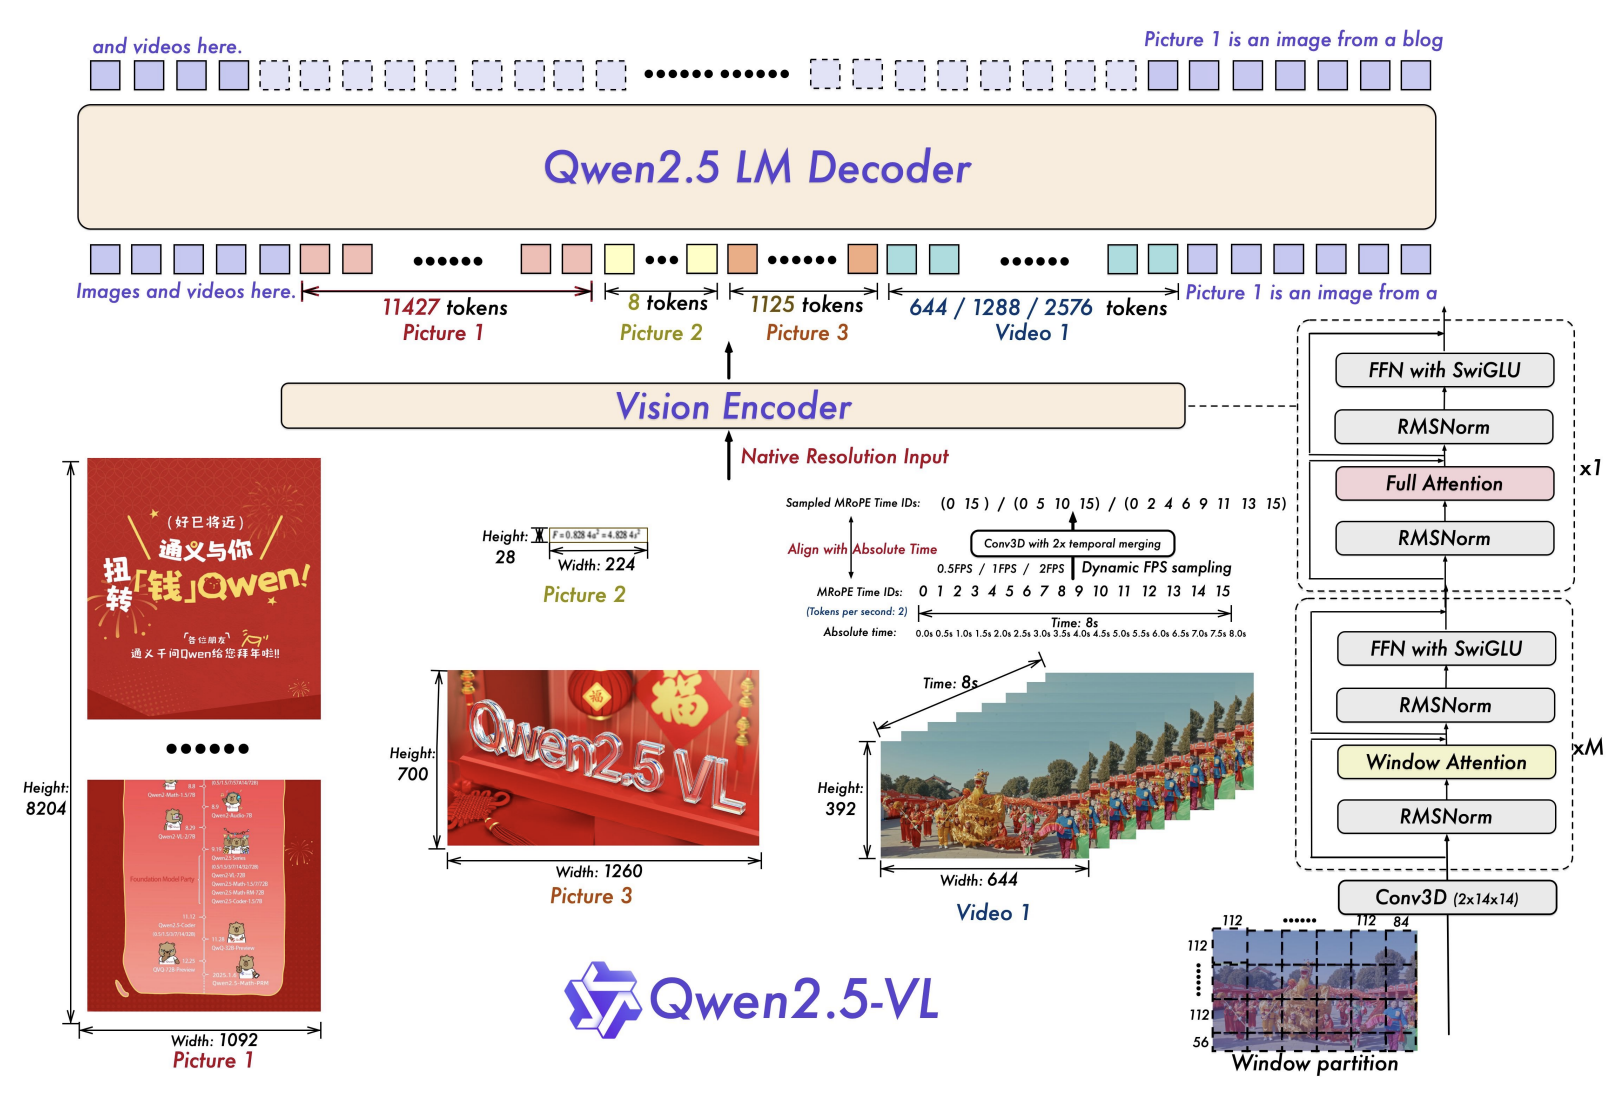

From [Qwen2.5VL Tech Report](https://arxiv.org/abs/2502.13923)

From this disgram in the  Qwen2.5VL tech report, you can see how it uses "native resolution" in then.

Interestingly, this means that input image resolution directly impacts tokens/pixel, and therefore you can get [image understanding performance boosts](https://github.com/QwenLM/Qwen2.5-VL?tab=readme-ov-file#image-resolution-for-performance-boost) from simply zooming images before they are passed to qwen.

## GLM 4.5V
Another state of the art VLM (circa Aug 2025) is GLM4.5V, which makes use of a similar image encoder architecture.
See the [GLM4.5V paper](https://arxiv.org/abs/2507.01006)
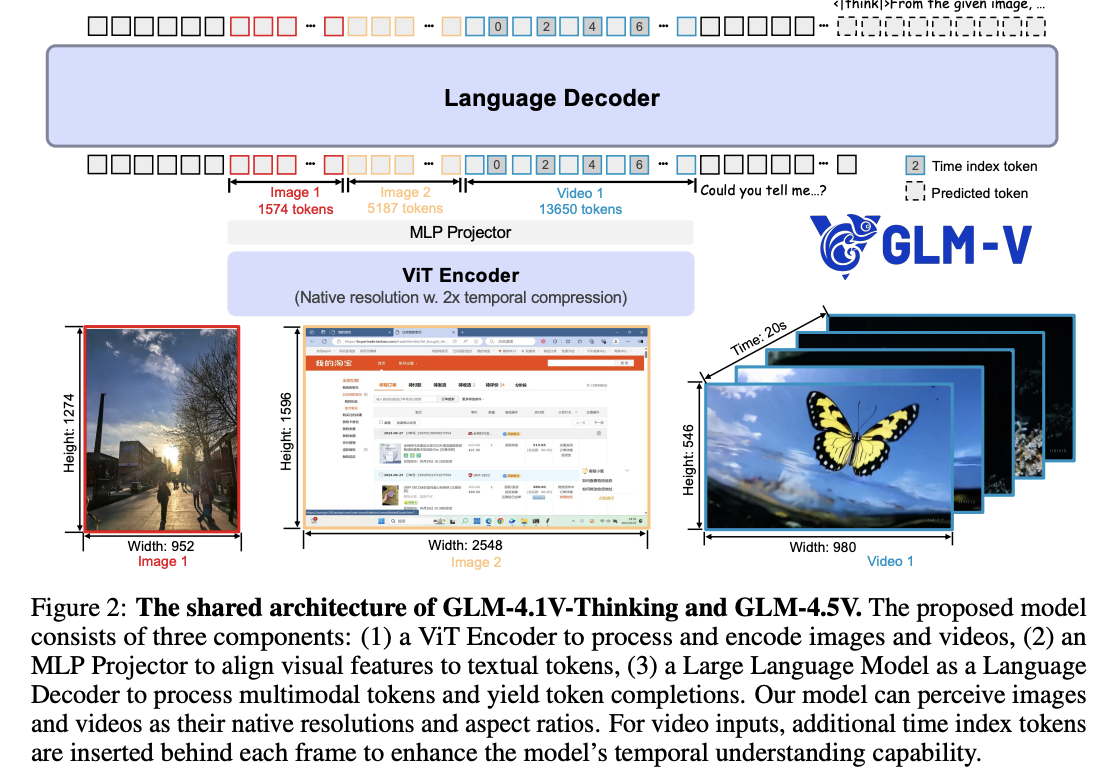

### Anatomy of model implementation

Our above discussion talks about theoretically how data is transformed through the various codepaths for the model, but how do you actually get your hands on the model to use it?

We'll focus on Huggingface Checkpoints and `transformers` library as a jumping off point for the discussion since they are well supported and acknowledged across the ecosystem For instance Amazon's [TnX (Transformers neuronX)](https://awsdocs-neuron.readthedocs-hosted.com/en/latest/libraries/transformers-neuronx/transformers-neuronx-developer-guide.html#transformers-neuronx-developer-guide) library had [previously](https://awsdocs-neuron.readthedocs-hosted.com/en/latest/libraries/nxd-inference/developer_guides/migrate-from-tnx-to-nxdi.html) provided an implementation of `transformers` library functionality for Annapurna Labs Neuron Silicon.  And Huggingface Checkpoints are fully supported for [conversion to compiled TRT-LLM checkpoints](https://nvidia.github.io/TensorRT-LLM/1.0.0rc4/architecture/checkpoint.html). (_NOTE_: Details on implementation and use of these optimized solutions will be covered in later parts on compiled models)


For a more thorough discussion, you should check out the discussion in [HuggingFace's LLM Course](https://huggingface.co/learn/llm-course/en/chapter2/1?fw=pt)

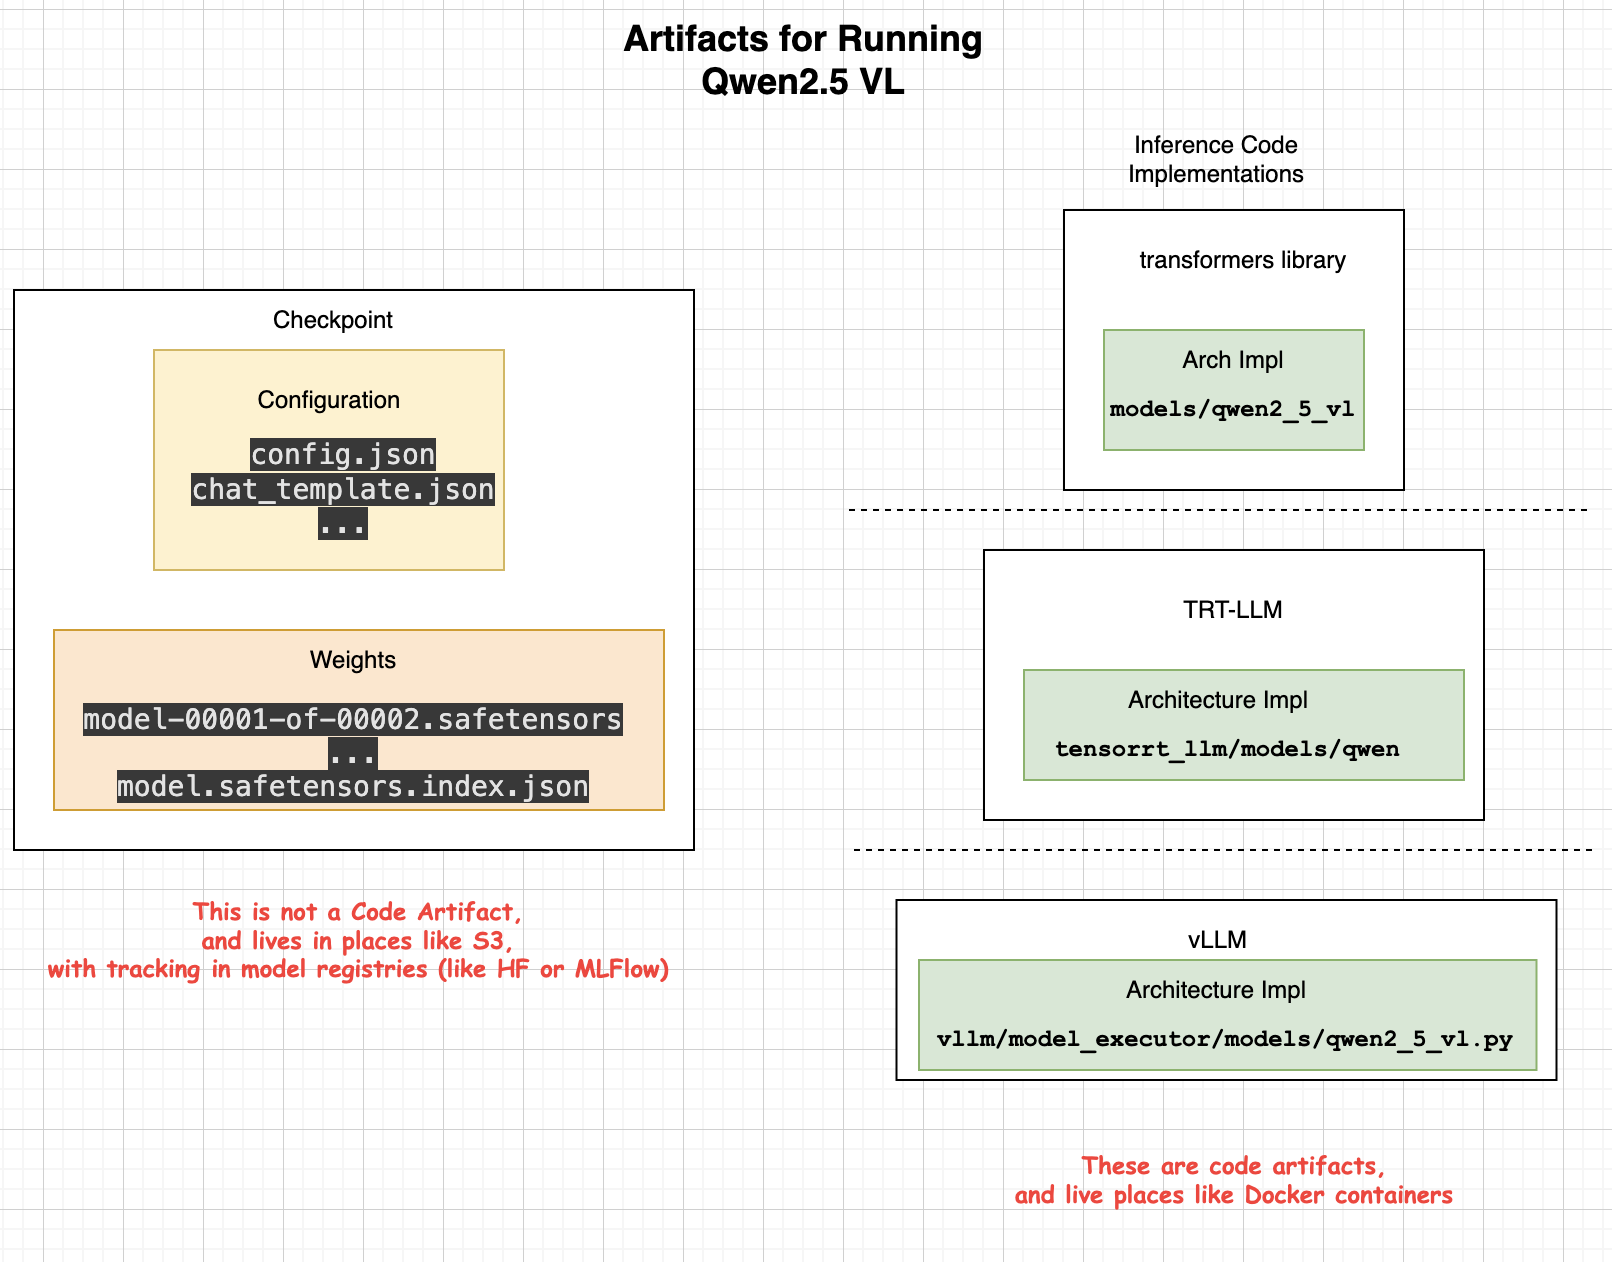

#### Huggingface Checkpoints
Huggingface has become a ubiquitious repository for open model weights and configurations, which are then can be used downstream by other implementations, or for further fine-tuning or optimization.


In [ ]:
!pwd

/content


In [ ]:
!git lfs install
!git clone https://huggingface.co/Qwen/Qwen2.5-VL-3B-Instruct /content/Qwen2.5-VL-3B-Instruct/

Git LFS initialized.
Cloning into '/content/Qwen2.5-VL-3B-Instruct'...
remote: Enumerating objects: 49, done.
remote: Counting objects: 100% (46/46), done.
remote: Compressing objects: 100% (46/46), done.
remote: Total 49 (delta 19), reused 0 (delta 0), pack-reused 3 (from 1)
Unpacking objects: 100% (49/49), 3.62 MiB | 3.25 MiB/s, done.
Filtering content: 100% (2/2), 6.99 GiB | 135.37 MiB/s, done.


In [ ]:
%cd /content/Qwen2.5-VL-3B-Instruct/
!git lfs pull
%cd ..

/content/Qwen2.5-VL-3B-Instruct
/content


First, let's look at the files in the checkpoint, you can view these in browser on huggingface as well: https://huggingface.co/Qwen/Qwen2.5-VL-3B-Instruct/tree/main.

You can see below that specifically, this `transformers` or other libraries that can use this checkpoint use this part of the config to understand the model architecture this config is relevant to (more on the codepath later).



1. Checkpoint Config

In [ ]:
!ls /content/Qwen2.5-VL-3B-Instruct/

chat_template.json	model-00001-of-00002.safetensors  tokenizer_config.json
config.json		model-00002-of-00002.safetensors  tokenizer.json
generation_config.json	model.safetensors.index.json	  vocab.json
LICENSE			preprocessor_config.json
merges.txt		README.md


In [ ]:
!head /content/Qwen2.5-VL-3B-Instruct/config.json

{
  "architectures": [
    "Qwen2_5_VLForConditionalGeneration"
  ],
  "attention_dropout": 0.0,
  "bos_token_id": 151643,
  "eos_token_id": 151645,
  "vision_start_token_id": 151652,
  "vision_end_token_id": 151653,
  "vision_token_id": 151654,


You can see below that specifically, this transformers or other libraries that can use this checkpoint use this part of the config to understand the model architecture this config is relevant to (more on the codepath later).  In this ase, you can see the configuration is

In [ ]:
!jq '.architectures' Qwen2.5-VL-3B-Instruct/config.json

[
  "Qwen2_5_VLForConditionalGeneration"
]


Most interesting in this context, is the vision configuration.

In [ ]:
!jq '.vision_config' Qwen2.5-VL-3B-Instruct/config.json

{
  "depth": 32,
  "hidden_act": "silu",
  "hidden_size": 1280,
  "intermediate_size": 3420,
  "num_heads": 16,
  "in_chans": 3,
  "out_hidden_size": 2048,
  "patch_size": 14,
  "spatial_merge_size": 2,
  "spatial_patch_size": 14,
  "window_size": 112,
  "fullatt_block_indexes": [
    7,
    15,
    23,
    31
  ],
  "tokens_per_second": 2,
  "temporal_patch_size": 2
}


2. Model Weights

The other interesting part of checkpoints are the model weights, and configurations that show how the model weights map into the actual architecture.

In [ ]:
# Let's look for some of the vision projector parameter weights
!cat Qwen2.5-VL-3B-Instruct/model.safetensors.index.json | grep visual | head

    "visual.blocks.0.attn.proj.bias": "model-00001-of-00002.safetensors",
    "visual.blocks.0.attn.proj.weight": "model-00001-of-00002.safetensors",
    "visual.blocks.0.attn.qkv.bias": "model-00001-of-00002.safetensors",
    "visual.blocks.0.attn.qkv.weight": "model-00001-of-00002.safetensors",
    "visual.blocks.0.mlp.down_proj.bias": "model-00001-of-00002.safetensors",
    "visual.blocks.0.mlp.down_proj.weight": "model-00001-of-00002.safetensors",
    "visual.blocks.0.mlp.gate_proj.bias": "model-00001-of-00002.safetensors",
    "visual.blocks.0.mlp.gate_proj.weight": "model-00001-of-00002.safetensors",
    "visual.blocks.0.mlp.up_proj.bias": "model-00001-of-00002.safetensors",
    "visual.blocks.0.mlp.up_proj.weight": "model-00001-of-00002.safetensors",


This provides a map of which layers load which weights.  These "safetensors" are really just serializations of model weights, you can see here for one of the MLP weights.

In [ ]:
from safetensors import safe_open

# Choose your tensor name
tensor_name = "visual.blocks.0.mlp.up_proj.weight"
shard_path = "Qwen2.5-VL-3B-Instruct/model-00001-of-00002.safetensors"

with safe_open(shard_path, framework="pt", device="cpu") as f:
    tensor = f.get_tensor(tensor_name)
    print(tensor.shape)
    print(tensor)

torch.Size([3420, 1280])
tensor([[ 0.0143, -0.0177, -0.0203,  ...,  0.0114, -0.0093,  0.0194],
        [ 0.0145,  0.0200,  0.0101,  ..., -0.0096,  0.0251, -0.0182],
        [-0.0449, -0.0059,  0.0327,  ..., -0.0298,  0.0253, -0.0102],
        ...,
        [ 0.0020, -0.0192,  0.0059,  ...,  0.0079, -0.0150,  0.0139],
        [ 0.0288,  0.0344, -0.0049,  ...,  0.0366, -0.0144,  0.0344],
        [-0.0116, -0.0008,  0.0308,  ..., -0.0079, -0.0092, -0.0137]],
       dtype=torch.bfloat16)



#### HF Transformers Library

Transformers has broad model support related  




### Code Deep-dive
Let's look at how this is implemented in transformers, and outputs of different stages.

For this exercise, we're going to look at Qwen2.5VL 1.5B due to it's smaller size and cheaper inference time.  Architecturally, same points should apply to larger variants like 72B (though practicalities of running these are different, but we'll get to that in a later section).

In [ ]:
# Get latest transformers release, at the time of writing
!git clone --branch v4.54.0 https://github.com/huggingface/transformers.git /content/transformers

Cloning into '/content/transformers'...
remote: Enumerating objects: 341569, done.
remote: Counting objects: 100% (450/450), done.
remote: Compressing objects: 100% (266/266), done.
remote: Total 341569 (delta 352), reused 184 (delta 184), pack-reused 341119 (from 4)
Receiving objects: 100% (341569/341569), 354.52 MiB | 17.73 MiB/s, done.
Resolving deltas: 100% (259857/259857), done.
Note: switching to '3fd456b200ba434e567412cc4517309482653f60'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false



In [ ]:
%cd /content/transformers
!pip uninstall -y transformers
!pip install -e .

# Restart runtime after install (required for editable installs to take effect)
import os
os.kill(os.getpid(), 9)

/content/transformers
Found existing installation: transformers 4.56.1
Uninstalling transformers-4.56.1:
  Successfully uninstalled transformers-4.56.1
Obtaining file:///content/transformers
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 87.5 MB/s eta 0:00:00
  Building editable for transformers (pyproject.toml) ... done
  Created wheel for transformers: filename=transformers-4.54.0-0.editable-py3-none-any.whl size=15466 sha256=b3c23983d26888f6af4f7fe8e9fa86aa42bc272cd3ec2c704fe67682be74342f
  Stored in directory: /tmp/pip-ephem-wheel-cache-tw722m_n/wheels/5d/95/aa/7bf76982b5186f967ea8b0d48a21290fa6c5c65b1e12ae5460
Successfully built transformers
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.22.0
    Uninstalling tokenizers-0.22.0:
      S

### *Restart Your Session  HERE*
Due to reinstallation of transformers, you need to restart so you're getting the version we just installed from source.

The above code just killed the session, so you should be able restart below.

In [ ]:
import json
import torch
import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModel

In [ ]:
print(transformers.__file__)

/content/transformers/src/transformers/__init__.py


`AutoModel` is used to instantiate an architecture based on the `config.json` file we viewed above, based on the `architectures` field.

In [ ]:
# Instantiate the model using AutoModel and the downloaded checkpoint
model_path = "/content/Qwen2.5-VL-3B-Instruct"
model = AutoModel.from_pretrained(model_path, torch_dtype=torch.float16, device_map="auto")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

You can see that the model in `transformers` is really just specified as a pytorch Module. (While different than the implementation in the [official Qwen repo](https://github.com/QwenLM/Qwen2.5-VL), this is nonetheless a PyTorch model that implements Qwen2.5 VL)


In [ ]:
import torch.nn as nn

print(f"Is a transformers model and instance of PyTorch nn.Module? {isinstance(model, nn.Module)}!")
print(model)

Is a transformers model and instance of PyTorch nn.Module? True!
Qwen2_5_VLModel(
  (visual): Qwen2_5_VisionTransformerPretrainedModel(
    (patch_embed): Qwen2_5_VisionPatchEmbed(
      (proj): Conv3d(3, 1280, kernel_size=(2, 14, 14), stride=(2, 14, 14), bias=False)
    )
    (rotary_pos_emb): Qwen2_5_VisionRotaryEmbedding()
    (blocks): ModuleList(
      (0-31): 32 x Qwen2_5_VLVisionBlock(
        (norm1): Qwen2RMSNorm((1280,), eps=1e-06)
        (norm2): Qwen2RMSNorm((1280,), eps=1e-06)
        (attn): Qwen2_5_VLVisionAttention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (mlp): Qwen2_5_VLMLP(
          (gate_proj): Linear(in_features=1280, out_features=3420, bias=True)
          (up_proj): Linear(in_features=1280, out_features=3420, bias=True)
          (down_proj): Linear(in_features=3420, out_features=1280, bias=True)
          (act_fn): SiLU()
        )
      )

#### Image Embeddings
*Next*, let's embed an image of some cute cats using the `visual` module from Qwen.

In [ ]:
from PIL import Image
from transformers import AutoProcessor
import requests
import torch


# Get the processor for preprocessing
processor = AutoProcessor.from_pretrained(model_path)

# Load an example image
image_url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(image_url, stream=True).raw)
inputs = processor(images=image, text=["<|image|>"], return_tensors="pt")

pixel_values = inputs["pixel_values"].to(model.device)
grid_thw = inputs["image_grid_thw"].to(model.device)

image_embeds = model.visual(pixel_values, grid_thw=grid_thw)
print(f"Image Embedding Shape: {image_embeds.shape}")

The image processor of type `Qwen2VLImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. Note that this behavior will be extended to all models in a future release.
You have video processor config saved in `preprocessor.json` file which is deprecated. Video processor configs should be saved in their own `video_preprocessor.json` file. You can rename the file or load and save the processor back which renames it automatically. Loading from `preprocessor.json` will be removed in v5.0.


Image Embedding Shape: torch.Size([391, 2048])


In [ ]:
import gc
del(inputs)
del(pixel_values)
del(grid_thw)
del(image_embeds)
torch.cuda.empty_cache()
gc.collect()

30

Let's do a 2x zoom on the image, and then see how token size increases. As mentioned above, this is you you can increase # of tokens per pixel

In [ ]:
zoomed_image = image.resize((image.size[0] * 2, image.size[1] * 2), resample=Image.BICUBIC)
inputs = processor(images=zoomed_image, text=["<|image|>"], return_tensors="pt")

pixel_values = inputs["pixel_values"].to(model.device)
grid_thw = inputs["image_grid_thw"].to(model.device)

image_embeds = model.visual(pixel_values, grid_thw=grid_thw)
print(f"Image Embedding Shape: {image_embeds.shape}")

Image Embedding Shape: torch.Size([1564, 2048])


You can see that the above tokenized image embedding's 2nd dimension matches the hidden dimension of the LLM as you can see from the model config:



In [ ]:
!echo "Model Hidden size:"
!jq '.hidden_size' Qwen2.5-VL-3B-Instruct/config.json

Model Hidden size:
2048


#### Text Embeddings

I encourage you to have a look at the [HuggingFace's LLM Course](https://huggingface.co/learn/llm-course/en/chapter2/4?fw=pt) tutorials on text embedding for a more thorough treatment.  Here, we'll just quickly convince ourselves that text embeddings can indeed be concatenated with image embeddings in a way that can be passed to an LLM.

In [ ]:
from transformers import AutoTokenizer

# Instantiate the tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_path)

# Text to tokenize
text = "What color are these cats?"

# Generate token IDs
token_ids = tokenizer.encode(text, return_tensors="pt")

print(f"Generated {token_ids.shape[1]} tokens from the text \"{text}\"")
print(token_ids)

Generated 6 tokens from the text "What color are these cats?"
tensor([[ 3838,  1894,   525,  1493, 19423,    30]])


See that in the above case, we happened to generate 6 tokens, these correspond to 6 different embedding vectors, we can view these directly below:

In [ ]:
# Access the language model's embedding layer
language_model_embeddings = model.language_model.embed_tokens

# Get embeddings for the token IDs
with torch.no_grad():
  text_embeddings = language_model_embeddings(token_ids.to(model.device))

print(text_embeddings.shape)
print(text_embeddings)

torch.Size([1, 6, 2048])
tensor([[[ 0.0248,  0.0042, -0.0206,  ...,  0.0110, -0.0121, -0.0138],
         [ 0.0042,  0.0074,  0.0126,  ..., -0.0332,  0.0289,  0.0327],
         [ 0.0154, -0.0093, -0.0186,  ..., -0.0028,  0.0146, -0.0088],
         [ 0.0322,  0.0131, -0.0172,  ..., -0.0029,  0.0381, -0.0145],
         [-0.0173, -0.0094,  0.0107,  ...,  0.0081,  0.0139,  0.0299],
         [ 0.0168,  0.0083, -0.0029,  ..., -0.0181, -0.0148,  0.0159]]],
       device='cuda:0', dtype=torch.float16)


### Running End-to-End

We can run the entire model end-to-end with `transformers` using the recommended snippet from the Qwen2.5-VL huggingface page: https://huggingface.co/Qwen/Qwen2.5-VL-3B-Instruct#using-%F0%9F%A4%97--transformers-to-chat


NOTE: Keep in mind that while Qwen2.5-VL-3B is a "small" model, it still has some serious GPU requirements, so make sure to run.  Also, depending on GPU type, you might just want to restart your notebook at this point to be sure all VRAM is free'd.

In [ ]:
!pip install qwen_vl_utils

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 59.1 MB/s eta 0:00:00


In [ ]:
from transformers import Qwen2_5_VLForConditionalGeneration, AutoTokenizer, AutoProcessor
from qwen_vl_utils import process_vision_info
model_path = "/content/Qwen2.5-VL-3B-Instruct"
# default: Load the model on the available device(s)
model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    model_path, torch_dtype="auto", device_map="auto"
)
# default processer
processor = AutoProcessor.from_pretrained("Qwen/Qwen2.5-VL-3B-Instruct")


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

chat_template.json: 0.00B [00:00, ?B/s]

In [ ]:

messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
                "image": "http://images.cocodataset.org/val2017/000000039769.jpg",
            },
            {"type": "text", "text": "What color are these cats?"},
        ],
    }
]


# Preparation for inference
text = processor.apply_chat_template(
    messages, tokenize=False, add_generation_prompt=True
)
image_inputs, video_inputs = process_vision_info(messages)
inputs = processor(
    text=[text],
    images=image_inputs,
    videos=video_inputs,
    padding=True,
    return_tensors="pt",
)
inputs = inputs.to("cuda")

# Inference: Generation of the output
generated_ids = model.generate(**inputs, max_new_tokens=128)
generated_ids_trimmed = [
    out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
]
output_text = processor.batch_decode(
    generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
)
print(output_text)

['The cats in the picture are tabby cats, which typically have a striped or spotted coat pattern. They can come in various colors, including brown, black, orange, and gray. The exact color of the cats in this image is not specified, but they likely fall within the common tabby patterns.']


## Resolution Scaling - LLaVA-NEXT

Some image encoding heads use a patching strategy to achieve arbitrary resolution processing with global context.

See [LLaVA-NeXT: Improved reasoning, OCR, and world knowledge](https://llava-vl.github.io/blog/2024-01-30-llava-next/)
and the updated [LLaVA-1.5 Technical report](https://static.hliu.cc/files/llava/improved_llava.pdf) for LLaVA-1.5 HD image encoding.


Note that this is different than the native resolution approach of Qwen2.5 VL and GLM 4.5V.

- [GLM-4.5V and GLM-4.5V Thinking Paper](https://arxiv.org/abs/2507.01006)
- [Qwen2.5-VL Techincal Report](https://arxiv.org/abs/2502.13923)



Using this dynamic resolution, you can see, for example a 2x2 grid, will result in 5 images being encoded by a ViT (concidentally necessitating batched inference of the image encoding ViT)

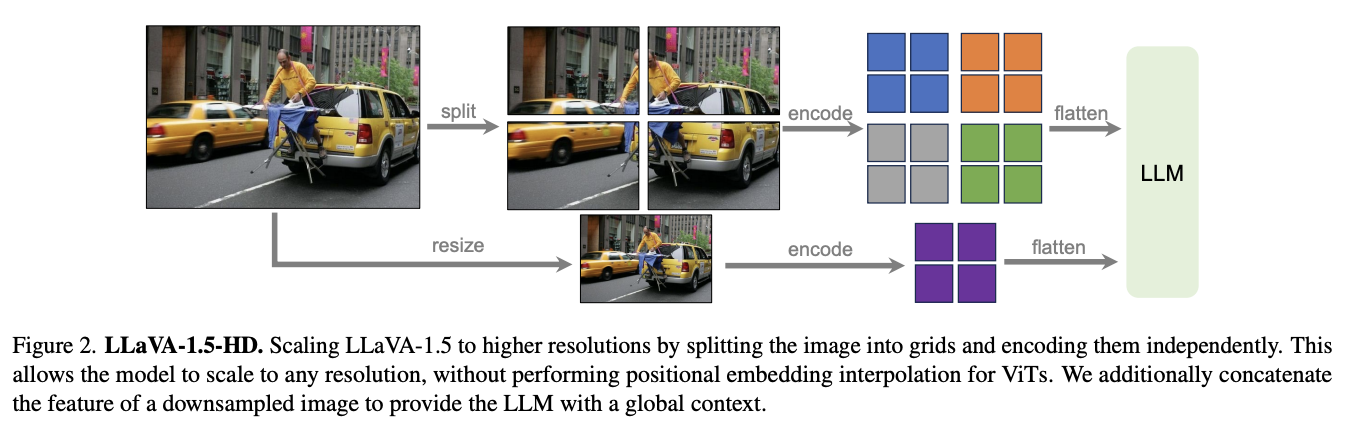

In [ ]:
# Let's look at the specific config for a 7B model
!mkdir -p /content/lava-v1.6-vicuna-7b-hf-download/
!curl -L https://huggingface.co/llava-hf/llava-v1.6-vicuna-7b-hf-download/resolve/main/config.json -o /content/lava-v1.6-vicuna-7b-hf/config.json
!jq '.architectures' /content/lava-v1.6-vicuna-7b-hf-download/config.json

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0Warning: Failed to create the file 
100    29  100    29    0     0     92      0 --:--:-- --:--:-- --:--:--    92
curl: (23) Failure writing output to destination
jq: error: Could not open file /content/lava-v1.6-vicuna-7b-hf-download/config.json: No such file or directory


### View Chunking Config
Let's look at the grid points in the model config, this tells us different resolutions that are available for breaking down the image

In [ ]:
!jq '.image_grid_pinpoints' /content/lava-v1.6-vicuna-7b-hf-download/config.json

jq: error: Could not open file /content/lava-v1.6-vicuna-7b-hf-download/config.json: No such file or directory


See `image_grid_pinpoints` in the docstring below:

In [ ]:
import transformers
from transformers.models.llava_next.image_processing_llava_next import LlavaNextImageProcessor
print(LlavaNextImageProcessor.__doc__)


    Constructs a LLaVa-NeXT image processor. Based on [`CLIPImageProcessor`] with incorporation of additional techniques
    for processing high resolution images as explained in the [LLaVa paper](https://huggingface.co/papers/2310.03744).

    Args:
        do_resize (`bool`, *optional*, defaults to `True`):
            Whether to resize the image's (height, width) dimensions to the specified `size`. Can be overridden by
            `do_resize` in the `preprocess` method.
        size (`dict[str, int]` *optional*, defaults to `{"shortest_edge": 224}`):
            Size of the image after resizing. The shortest edge of the image is resized to size["shortest_edge"], with
            the longest edge resized to keep the input aspect ratio. Can be overridden by `size` in the `preprocess`
            method.
        image_grid_pinpoints (`List` *optional*, defaults to `[[672, 336], [336, 672], [672, 672], [336, 1008], [1008, 336]]`):
            A list of possible resolutions to use for p

### Chunked Image encoding
Now, let's have a look at the encoded image chunks

In [ ]:
from transformers import LlavaNextProcessor, LlavaNextForConditionalGeneration
import torch
from PIL import Image
import requests

processor = LlavaNextProcessor.from_pretrained("llava-hf/llava-v1.6-vicuna-7b-hf")

model = LlavaNextForConditionalGeneration.from_pretrained("llava-hf/llava-v1.6-vicuna-7b-hf", torch_dtype=torch.float16, low_cpu_mem_usage=True)
model.to("cuda:0")

# prepare image and text prompt, using the appropriate prompt template
url = "https://github.com/haotian-liu/LLaVA/blob/1a91fc274d7c35a9b50b3cb29c4247ae5837ce39/images/llava_v1_5_radar.jpg?raw=true"
image = Image.open(requests.get(url, stream=True).raw)

# Define a chat histiry and use `apply_chat_template` to get correctly formatted prompt
# Each value in "content" has to be a list of dicts with types ("text", "image")
conversation = [
    {

      "role": "user",
      "content": [
          {"type": "text", "text": "What is shown in this image?"},
          {"type": "image"},
        ],
    },
]
prompt = processor.apply_chat_template(conversation, add_generation_prompt=True)

inputs = processor(images=image, text=prompt, return_tensors="pt").to("cuda:0")


preprocessor_config.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/552 [00:00<?, ?B/s]

processor_config.json:   0%|          | 0.00/176 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/700 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.18G [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

Observe that the output tensor size along the image batch dimension is 5, as previously discussed, e.g. 4 chunks + 1 resized full frame.

Dimensions for the tensor here are:

`[ Prompt, Image Batch, Channel, Height, Width]`


*Image Data Representation*

`Channel` here refers to a dimension in how color information ("color space") in the image is represented, e.g. 3 for RGB, or 1 for Black and White.


If you're unfamiliar with Tensor or matrix representation of images, check out the [OpenCV documentation on colorspace transformation](https://docs.opencv.org/4.x/df/d9d/tutorial_py_colorspaces.html).  While it has a `numpy` matrix representation of images, this is conceptually similar to Tensor representation.

*Batching*

`Image Batch` above refers to the number of images that are being processed at the same time.  You can in a sense think about how the same vectorized matrix operations can be applied to arbitrarily many rows in a matrix (this r


In [ ]:
inputs['pixel_values'].shape

torch.Size([1, 5, 3, 336, 336])

## Appendix A: What Are Embeddings

You've seen "embeddings" mentioned a few times in the above notebook.  Different models have different embeddings (for instance how the ViT output needs to be projected to the same latent space as the text embeddings).



I find this Word Embedding Tutorial, including vector arithmetic very helpful for understanding how embeddings capture semantic meaning of text:
https://www.cs.cmu.edu/~dst/WordEmbeddingDemo/tutorial.html

![image](https://www.cs.cmu.edu/~dst/WordEmbeddingDemo/figures/fig4.png)

This forms the basis for ANN, like in [FAISS](https://www.pinecone.io/learn/series/faiss/vector-indexes/), that are used in [RAG](https://qdrant.tech/articles/what-is-rag-in-ai/) and [semantic search](https://www.elastic.co/search-labs/blog/lexical-and-semantic-search-with-elasticsearch) applications.


For further reading to intuitively understand embeddings, I recommend Google's ML Crash course explanation of embeddings: https://developers.google.com/machine-learning/crash-course/embeddings


## Appendix B: What is a ViT?

A ViT is a vision transformer, think about applying a pretty vanilla transformer architecture to an image in patches.

#### Intro to ViTs
I recommend this tutorial from University of Amsterdam for better understanding ViTs: https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial15/Vision_Transformer.html

#### CLIP Alignment for ViTs

Check out OpenAI's post about CLIP and how it can be used to align image embeddings with text descriptions:

https://openai.com/index/clip/

![image](https://images.ctfassets.net/kftzwdyauwt9/fbc4f633-9ad4-4dc2-3809c22df5e0/0bd2d5abf90d052731538613e4a42668/overview-a.svg)

Also reference the Llava paper, and citations, that discuss CLIP alignment of the ViT for use in Llava architecture. https://arxiv.org/abs/2304.08485




# Further Reading
- [Llava-NeXT Blog](https://llava-vl.github.io/blog/2024-01-30-llava-next/)

## Thanks for Reading!

Any questions / comments / improvements can be left via github issues, or contacting via github user [`b-koopman`](https://github.com/b-koopman).